# Warmup: Estimating Discount Factors, continued

Previously we saw that discount factors $z$ can be estimated by solving a linear system of equations
$$
  Cz = p.
$$
The system is typically underdetermined, and we saw that we can obtain more plausible discount factors by introducing constraints and solving a QP.

Now we introduce more regularity while maintaining simple linear system connecting obseved prices to state.

Consider the factors generated by the basis functions
$$
   \Phi_k(t,r) = 1-\exp\left(-rkt\right), r>0.
$$
Note that $\Phi_k(0,r)=0$ for all $k$ and $r$.

Define the discount function
$$
   z_K(t,x,r) = 1 + \sum_{k=1}^K x_k\Phi_k(t,r)
$$
with linear weights $x\in R^K$.
We naturally have 
$$
  z_K(0,x,r) = 1,
$$
but we only have 
$$
  0 = z_K(\infty,x,r) = 1 + \sum_{k=1}^K x_k
$$
if
$$
   \sum_{k=1}^K x_k = -1.
$$

Assume the times corresponding to the columns of $C$ are given by $t_m$, $m=1,\dots,M$. By forming the matrix $F$ with entries $F_{ij} = \Phi_j(t_m)$ we have arrived at needing to solve the system
$$\begin{gather}
   C(1+Fx) = p \\
   \left[1\, 1 \dots 1\right] x = -1 \\
   0 \leq 1+Fx \leq1
\end{gather}$$
Since $z=1+Fx$ is a linear combination of decreasing functions, $z$ will be decreasing as well.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import quadprog as qp
import matplotlib.pylab as plt

In [2]:
bond_df = pd.read_csv('./Data/sample-bonds-1.csv')
bond_df.head()

,coupon,dirty price,maturity,pd-1,pd-2,pd-3,pd-4,pd-5,pd-6,pd-7,pd-8,pd-9
0,2.375,101.9825,5/15/2018,11/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.250,105.4372,12/15/2019,6/15/2019,12/15/2018,6/15/2018,12/15/2017,NaN,NaN,NaN,NaN,NaN
2,1.875,101.7911,1/15/2020,7/15/2019,1/15/2019,7/15/2018,1/15/2018,NaN,NaN,NaN,NaN,NaN
3,1.375,98.9160,3/31/2021,9/30/2020,3/31/2020,9/30/2019,3/31/2019,9/30/2018,3/31/2018,NaN,NaN,NaN
4,4.125,110.0907,10/15/2022,4/15/2022,10/15/2021,4/15/2021,10/15/2020,4/15/2020,10/15/2019,4/15/2019,10/15/2018,4/15/2018


In [3]:
T0 = dt.datetime(2017,11,7)
pd = [ [(dt.datetime.strptime(x,'%m/%d/%Y')-T0).days if type(x) is str else 0 for j,x in item.iteritems()] for i, item in bond_df.iloc[:,2:].iterrows()]

In [4]:
u_pd = np.unique(np.ravel(pd))
u_pd = u_pd[np.where(u_pd>0)]
n = len(bond_df)
m = len(u_pd)
print('%d bonds and %d cashflow dates' % (n,m) )

5 bonds and 29 cashflow dates


In [5]:
p = np.array(bond_df['dirty price'])
C = np.zeros( (n,m) )
for i in range(n):
    c = 0.5*bond_df.iloc[i,0]
    for k,x in enumerate(pd[i]):
        if x>0:
            j = np.where(u_pd==x)[0][0]
            C[i,j] = c if k > 0 else 100+c

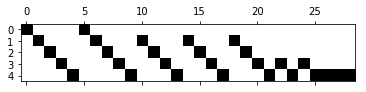

In [6]:
plt.spy(C);
plt.show();

## Create the matrix $F$

In [7]:
tm = u_pd/365.0;
r = 0.03
K = 4
F = np.matrix([1-np.exp(-r*tm*k) for k in range(1,K+1)]).T

In [8]:
# Set up the problem with H = (CF)'CF and f - p'CF
v = p-C.dot(np.ones(m))
G = C.dot(F)
H = G.T.dot(G)
f = np.ravel(v.dot(G))

In [9]:
# Constraints
A = np.block( [
    [np.ones(K)],
    [-np.ones(K)],
    [F],
    [-F]
    ])
b = np.array(np.concatenate((-np.ones(1),np.ones(1),-np.ones(m),np.zeros(m))))

In [10]:
# Solve the QP
qp_res = qp.solve_qp(H,f,A.T,b)
x = qp_res[0]
z = np.ones(m)+np.ravel(F.dot(x))
print(z)
print('Error=%3.2g' % np.linalg.norm(C.dot(z)-p))

[ 0.99995478  0.99972884  0.99940398  0.99825144  0.99796126  0.99732375
  0.99658711  0.99580133  0.99347282  0.9929694   0.99076456  0.9895512
  0.98637409  0.98569971  0.98283205  0.98135145  0.97735523  0.9765458
  0.97315792  0.97138024  0.96687653  0.96596487  0.95531675  0.95433188
  0.94307909  0.94204678  0.92926421  0.9163754   0.90345906]
Error=0.17


Now we have a non-increasingfunction with values that look like discount factors and a very good fit - the error is within 17 cents.

As before, let's look at the implied zero rates $r(t)$, which are defined as
$$
   z_j = e^{-r(t_j)t_j}
$$

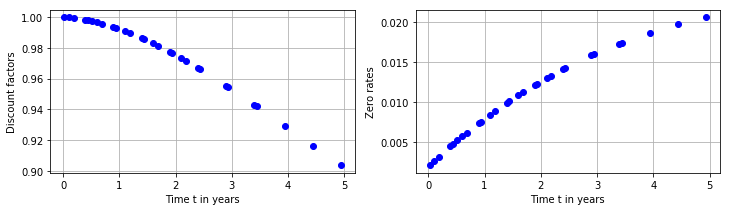

In [11]:

plt.figure( figsize=(12,3) )
plt.subplot(1,2,1)
plt.plot(tm, z,'bo');
plt.grid(True)
plt.xlabel('Time t in years')
plt.ylabel('Discount factors')
plt.subplot(1,2,2)
plt.plot(tm, -np.log(z)/tm,'bo');
plt.grid(True)
plt.xlabel('Time t in years')
plt.ylabel('Zero rates')
plt.show();

As expected, we now have smooth curves for both discount factors and zero rates - the regularity we were looking for.